## Loading libraries

In [1]:
import numpy as np

In [2]:
import pandas as pd

In [3]:
# sklearn
from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, precision_score, classification_report, recall_score, confusion_matrix

In [4]:
import matplotlib.pyplot as plt

In [5]:
import scipy.sparse as sp

In [6]:
# torch
import torch
import torch_scatter
import torch.nn as nn
from torch import Tensor
import torch.nn.functional as F
from torch_sparse import SparseTensor, set_diag
from torch.nn import Linear, LayerNorm, ReLU, Dropout, Parameter, Linear

In [7]:
# PyG
import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils
from torch_geometric.loader import NeighborLoader
from torch_geometric.data import Data, DataLoader
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.nn.norm.batch_norm import BatchNorm
from torch_geometric.nn import GCNConv,GATConv,GATv2Conv
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType, OptTensor)
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax, degree

In [165]:
# utilities
import random
import pickle
import warnings
warnings.filterwarnings("ignore")
from tqdm import tqdm
from typing import Union, Tuple, Optional

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Getting the data

In [10]:
# FOLDERNAME = "/content/"
# import sys
# sys.path.append(FOLDERNAME)

In [63]:
df_features = pd.read_csv('../../4_Elliptic_Bitcoin_Dataset_Fraud_detection_Standford/content/elliptic_txs_features.csv',header=None)
df_edges = pd.read_csv("../../4_Elliptic_Bitcoin_Dataset_Fraud_detection_Standford/content/elliptic_txs_edgelist.csv")
df_classes =  pd.read_csv("../../4_Elliptic_Bitcoin_Dataset_Fraud_detection_Standford/content/elliptic_txs_classes.csv")

In [64]:
# Add class names for easy understanding
# reformat classes 0:licit, 1:illicit, 2:unknow 
df_classes['class'] = df_classes['class'].map({'unknown': 2, '1':1, '2':0}) 

## Simple EDA

<BarContainer object of 3 artists>

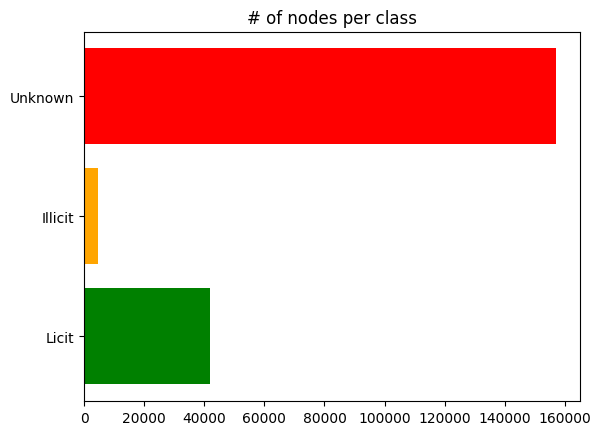

In [65]:
# See repartition of nodes per class
group_class = df_classes.groupby('class').count()
plt.title("# of nodes per class")
plt.barh([ 'Licit','Illicit', 'Unknown'], group_class['txId'].values, color=['g', 'orange', 'r'] )

In [66]:
# View node features
# Data is each node is a transaction ID, and edges are a bit weird, but its like a "previous transaction" edge type
# colume 0 = transaction id
df_features.head()

,0,1,2,3,4,5,6,7,8,9,...,157,158,159,160,161,162,163,164,165,166
0,230425980,1,-0.171469,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162097,...,-0.562153,-0.600999,1.461330,1.461369,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
1,5530458,1,-0.171484,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162112,...,0.947382,0.673103,-0.979074,-0.978556,0.018279,-0.087490,-0.131155,-0.097524,-0.120613,-0.119792
2,232022460,1,-0.172107,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.162749,...,0.670883,0.439728,-0.979074,-0.978556,-0.098889,-0.106715,-0.131155,-0.183671,-0.120613,-0.119792
3,232438397,1,0.163054,1.963790,-0.646376,12.409294,-0.063725,9.782742,12.414558,-0.163645,...,-0.577099,-0.613614,0.241128,0.241406,1.072793,0.085530,-0.131155,0.677799,-0.120613,-0.119792
4,230460314,1,1.011523,-0.081127,-1.201369,1.153668,0.333276,1.312656,-0.061584,-0.163523,...,-0.511871,-0.400422,0.517257,0.579382,0.018279,0.277775,0.326394,1.293750,0.178136,0.179117


In [67]:
# columns 1 is time column and spans from 1 to 49
# 1 corresponds to week 1 and week 2
# 2 corresponds to week 3 and week 4
# and soo on till 40
df_features[1]

0          1
1          1
2          1
3          1
4          1
          ..
203764    49
203765    49
203766    49
203767    49
203768    49
Name: 1, Length: 203769, dtype: int64

In [68]:
df_edges.head()

,txId1,txId2
0,230425980,5530458
1,232022460,232438397
2,230460314,230459870
3,230333930,230595899
4,232013274,232029206


In [69]:
df_classes.head()

,txId,class
0,230425980,2
1,5530458,2
2,232022460,2
3,232438397,0
4,230460314,2


## Preparing graph data object

In [70]:
# Merge features with classes
df_merge = df_features.merge(df_classes, how='left', right_on="txId", left_on=0)
df_merge = df_merge.sort_values(0).reset_index(drop=True)
df_merge.head()

,0,1,2,3,4,5,6,7,8,9,...,159,160,161,162,163,164,165,166,txId,class
0,1076,48,-0.168500,0.270909,-0.091383,-0.046932,-0.043875,-0.029140,-0.061584,-0.163591,...,1.461330,1.461369,0.018279,0.470019,1.216796,1.151607,1.519700,1.521399,1076,2
1,2534,6,-0.170834,-0.131425,1.018602,0.028105,0.055376,0.054722,-0.061584,-0.163572,...,0.955101,0.459257,-0.098889,-0.087490,-0.099080,-0.122137,-0.379970,-0.379288,2534,0
2,3181,34,1.305212,-0.210553,-1.756361,-0.121970,97.300650,-0.113002,-0.061584,1.348765,...,0.059948,0.113967,-0.098889,1.969527,0.037532,-0.131010,0.006994,0.017772,3181,0
3,3321,1,-0.169615,-0.184668,-1.201369,-0.121970,-0.043875,-0.113002,-0.061584,-0.160199,...,0.241128,0.241406,-0.098889,-0.087490,-0.084674,-0.140597,1.519700,1.521399,3321,2
4,3889,48,-0.086232,-0.101835,-0.646376,-0.121970,17.046997,-0.113002,-0.061584,-0.074885,...,0.082065,0.114773,-0.098889,8.948005,1.024948,-0.009570,-0.080708,-0.123601,3889,2


In [71]:
#We map all nodes to indices, and filter edges data by mapping txid1 and txid2 with the indices. We convert it to tensors, and initialize a weight tensor with the same length of the edge index and with values 1.

In [72]:
# Setup trans ID to node ID mapping
nodes = df_merge[0].values

map_id = {j:i for i,j in enumerate(nodes)} # mapping nodes to indexes

# Create edge df that has transID mapped to nodeIDs
edges = df_edges.copy()
edges.txId1 = edges.txId1.map(map_id) #get nodes idx1 from edges list and filtered data
edges.txId2 = edges.txId2.map(map_id)

edges = edges.astype(int)

edge_index = np.array(edges.values).T #convert into an array
edge_index = torch.tensor(edge_index, dtype=torch.long).contiguous() # create a tensor

print("shape of edge index is {}".format(edge_index.shape))
edge_index


shape of edge index is torch.Size([2, 234355])


tensor([[138670, 141325, 139232,  ..., 100420,  54833, 101159],
        [  4142, 142201, 139223,  ..., 100419,  81951, 101163]])

In [73]:
#create weights tensor with same shape of edge_index
weights = torch.tensor([1]* edge_index.shape[1] , dtype=torch.double) 

In [74]:
# Define labels
labels = df_merge['class'].values
print("lables", np.unique(labels))
labels

lables [0 1 2]


array([2, 0, 0, ..., 2, 2, 2], dtype=int64)

In [80]:
# for EWC
task1_indices = df_merge[df_merge[1] <= 25].index.tolist()
task2_indices = df_merge[df_merge[1] > 25].index.tolist()

In [81]:
# mapping txIds to corresponding indices, to pass node features to the model

node_features = df_merge.drop(['txId'], axis=1).copy()
# node_features[0] = node_features[0].map(map_id) # Convert transaction ID to node ID \
print("unique=",node_features["class"].unique())

# Retain known vs unknown IDs
classified_idx = node_features['class'].loc[node_features['class']!=2].index # filter on known labels
unclassified_idx = node_features['class'].loc[node_features['class']==2].index

classified_illicit_idx = node_features['class'].loc[node_features['class']==1].index # filter on illicit labels
classified_licit_idx = node_features['class'].loc[node_features['class']==0].index # filter on licit labels

# Drop unwanted columns, 0 = transID, 1=time period, class = labels
node_features = node_features.drop(columns=[0, 1, 'class'])

# Convert to tensor
node_features_t = torch.tensor(np.array(node_features.values, dtype=np.double), dtype=torch.double)# drop unused columns
node_features_t

unique= [2 0 1]


tensor([[-0.1685,  0.2709, -0.0914,  ...,  1.1516,  1.5197,  1.5214],
        [-0.1708, -0.1314,  1.0186,  ..., -0.1221, -0.3800, -0.3793],
        [ 1.3052, -0.2106, -1.7564,  ..., -0.1310,  0.0070,  0.0178],
        ...,
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1727, -0.1588, -1.2014,  ..., -0.2698, -0.1206, -0.1198],
        [-0.1433, -0.1588, -1.2014,  ..., -0.0975, -0.1206, -0.1198]],
       dtype=torch.float64)

In [90]:
# Create a known vs unknown mask
train_idx, valid_idx = train_test_split(classified_idx.values, test_size=0.15)
print("train_idx size {}".format(len(train_idx)))
print("tets_idx size {}".format(len(valid_idx)))

train_idx size 39579
tets_idx size 6985


In [91]:
data_train = Data(x=node_features_t, edge_index=edge_index, edge_attr=weights, 
                               y=torch.tensor(labels, dtype=torch.double))
# Add in the train and valid idx
data_train.train_idx = train_idx
data_train.valid_idx = valid_idx
data_train.test_idx = unclassified_idx

## testing for time

In [40]:
# these are indexes and not mask i need to pass mask not indexes to the neighborloader
# fixing it

In [86]:
task1_indices[:20]

[1, 3, 24, 25, 26, 30, 33, 41, 54, 56, 61, 63, 64, 67, 68, 69, 70, 73, 80, 81]

In [87]:
task2_indices[:20]

[0, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21]

## DataLoader functions

In [35]:
def get_neighbor_loader(data, indices, neighbors_arr, batch_size):
    
    loader=NeighborLoader(
        data,
        input_nodes=indices,
        num_neighbors=neighbors_arr, #around 70 nodes at a time -> 10 * 5 = 50 and 5 * 4 = 20 -> 50 + 20 = 70
        batch_size=batch_size,
        replace=False,
        shuffle=True
    )

    return loader

## GNN models

### GCNConv

In [38]:
class Net(torch.nn.Module):
    def __init__(self, hidden_channels):
        super(Net, self).__init__()
        self.conv1 = GCNConv(165, 128)
        self.conv2 = GCNConv(128, 2)
        self.classifier = Linear(2, 1)
        self.double() #float64    # why was this needed?
        #https://stackoverflow.com/questions/75102134/mat1-and-mat2-must-have-the-same-dtype

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        embeddings = h.tanh()  # Final GNN embedding space.
        out = self.classifier(embeddings)
        return F.sigmoid(out)

In [ ]:

class GAT(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args):
        super(GAT, self).__init__()
        #use our gat message passing 
        self.conv1 = GATConv(input_dim, hidden_dim, heads=args['heads'])
        self.conv2 = GATConv(args['heads'] * hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim), nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)

In [ ]:
class GATv2(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args):
        super(GATv2, self).__init__()
        #use our gat message passing 
        self.conv1 = GATv2Conv(input_dim, hidden_dim, heads=args['heads'])
        self.conv2 = GATv2Conv(args['heads'] * hidden_dim, hidden_dim, heads=args['heads'])
        
        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim), nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)


In [2]:
class myGAT(MessagePassing):
    def __init__(self, in_channels, out_channels, heads = 1, 
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(myGAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels # node features input dimension
        self.out_channels = out_channels # node level output dimension
        self.heads = heads # No. of attention heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None

        # Initialization
        self.lin_l = Linear(in_channels, heads*out_channels)
        self.lin_r = self.lin_l
        self.att_l = Parameter(torch.Tensor(1, heads, out_channels).float())
        self.att_r = Parameter(torch.Tensor(1, heads, out_channels).float())
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels # DIM：H, outC

        #Linearly transform node feature matrix.
        x_source = self.lin_l(x).view(-1,H,C) # DIM: [Nodex x In] [in x H * outC] => [nodes x H * outC] => [nodes, H, outC]
        x_target = self.lin_r(x).view(-1,H,C) # DIM: [Nodex x In] [in x H * outC] => [nodes x H * outC] => [nodes, H, outC]

        # Alphas will be used to calculate attention later
        alpha_l = (x_source * self.att_l).sum(dim=-1) # DIM: [nodes, H, outC] x [H, outC] => [nodes, H]
        alpha_r = (x_target * self.att_r).sum(dim=-1) # DIM: [nodes, H, outC] x [H, outC] => [nodes, H]

        #  Start propagating messages (runs message and aggregate)
        out = self.propagate(edge_index, x=(x_source, x_target), alpha=(alpha_l, alpha_r),size=size) # DIM: [nodes, H, outC]
        out = out.view(-1, self.heads * self.out_channels) # DIM: [nodes, H * outC]

        return out

    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):
        # Calculate attention for edge pairs
        attention = F.leaky_relu((alpha_j + alpha_i), self.negative_slope) # EQ(1) DIM: [Edges, H]
        attention = softmax(attention, index, ptr, size_i) # EQ(2) DIM: [Edges, H] | This softmax only calculates it over all neighbourhood nodes
        attention = F.dropout(attention, p=self.dropout, training=self.training) # DIM: [Edges, H]

        # Multiple attention with node features for all edges
        out = x_j * attention.unsqueeze(-1)  # EQ(3.1) [Edges, H, outC] x [Edges, H] = [Edges, H, outC];

        return out

    def aggregate(self, inputs, index, dim_size = None):
        # EQ(3.2) For each node, aggregate messages for all neighbourhood nodes 
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, 
                                    dim_size=dim_size, reduce='sum') # inputs (from message) DIM: [Edges, H, outC] => DIM: [Nodes, H, outC]
        return out


NameError: name 'MessagePassing' is not defined

In [ ]:
class myGATv2(MessagePassing):
    def __init__(self, in_channels, out_channels, heads = 1,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(myGATv2, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        self.lin_l = None
        self.lin_r = None
        self.att_l = None
        self.att_r = None
        self._alpha = None
        # self.lin_l is the linear transformation that you apply to embeddings 
        # BEFORE message passing.
        self.lin_l =  Linear(in_channels, heads*out_channels)
        self.lin_r = self.lin_l

        self.att = Parameter(torch.Tensor(1, heads, out_channels))
        self.reset_parameters()

    #initialize parameters with xavier uniform
    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att)

    def forward(self, x, edge_index, size = None):
        
        H, C = self.heads, self.out_channels # DIM：H, outC
        #Linearly transform node feature matrix.
        x_source = self.lin_l(x).view(-1,H,C) # DIM: [Nodex x In] [in x H * outC] => [nodes x H * outC] => [nodes, H, outC]
        x_target = self.lin_r(x).view(-1,H,C) # DIM: [Nodex x In] [in x H * outC] => [nodes x H * outC] => [nodes, H, outC]
        
        #  Start propagating messages (runs message and aggregate)
        out= self.propagate(edge_index, x=(x_source,x_target),size=size) # DIM: [nodes, H, outC]
        out= out.view(-1, self.heads * self.out_channels)       # DIM: [nodes, H * outC]
        alpha = self._alpha
        self._alpha = None
        return out

    #Process a message passing
    def message(self, x_j,x_i,  index, ptr, size_i):
        #computation using previous equationss
        x = x_i + x_j                               
        x  = F.leaky_relu(x, self.negative_slope)   # See Equation above: Apply the non-linearty function
        alpha = (x * self.att).sum(dim=-1)          # Apply attnention "a" layer after the non-linearity 
        alpha = softmax(alpha, index, ptr, size_i)  # This softmax only calculates it over all neighbourhood nodes
        self._alpha = alpha
        alpha= F.dropout(alpha,p=self.dropout,training=self.training)
        # Multiple attention with node features for all edges
        out= x_j*alpha.unsqueeze(-1)  

        return out
    #Aggregation of messages
    def aggregate(self, inputs, index, dim_size = None):
        out = torch_scatter.scatter(inputs, index, dim=self.node_dim, 
                                    dim_size=dim_size, reduce='sum')  
        return out

In [3]:
class GATmodif(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args):
        super(GATmodif, self).__init__()
        #use our gat message passing 
        self.conv1 = myGAT(input_dim, hidden_dim,heads=args['heads'])
        self.conv2 = myGAT(args['heads']  *hidden_dim, hidden_dim,heads=args['heads']) 

        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim), nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)

class GATv2modif(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim,args):
        super(GATv2modif, self).__init__()
        #use our gat message passing 
        self.conv1 = myGATv2(input_dim, hidden_dim,heads=args['heads']) 
        self.conv2 = myGATv2(args['heads'] *hidden_dim, hidden_dim,heads=args['heads'])

        self.post_mp = nn.Sequential(
            nn.Linear(args['heads']  * hidden_dim, hidden_dim), nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)
 

NameError: name 'torch' is not defined

In [4]:
class GATmodif_3layer(torch.nn.Module):
    def __init__(self,input_dim, hidden_dim, output_dim, args):
        super(GATmodif_3layer, self).__init__()
        #use our gat message passing 
        self.conv1 = myGAT(input_dim, hidden_dim,heads=args['heads'])
        self.conv2 = myGAT(args['heads'] * hidden_dim, hidden_dim,heads=args['heads']) 
        self.conv3 = myGAT(args['heads'] * hidden_dim, hidden_dim,heads=args['heads']) 
        
        self.post_mp = nn.Sequential(
            nn.Linear(args['heads'] * hidden_dim, hidden_dim), nn.Dropout(args['dropout'] ), 
            nn.Linear(hidden_dim, output_dim))
        
    def forward(self, data, adj=None):
        x, edge_index = data.x, data.edge_index
        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # Layer 2
        x = self.conv2(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)
        
        # Layer 3
        x = self.conv3(x, edge_index)
        x = F.dropout(F.relu(x), p=args['dropout'], training=self.training)

        # MLP output
        x = self.post_mp(x)
        return F.sigmoid(x)

NameError: name 'torch' is not defined

## Training Utils

In [31]:
def train(model, optimizer, criterion, train_loader, epochs):
    for epoch in range(1, epochs+1):
        total_loss = 0
        total = 0
        model.train()
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            out = model(batch)
            out = out.reshape((batch.x.shape[0]))
            
            y = batch.y[:batch.batch_size]
            out = out[:batch.batch_size]
            
            loss = criterion(out, y)
            loss.backward()
            
            total += y.size(0)
            total_loss += loss.item() * y.size(0)   # always use loss.item() * y.size(0)
            
            optimizer.step()
        average_loss = total_loss / total
        print(f'Epoch: {epoch:03d}, Loss: {average_loss:.4f}')

In [32]:
def evaluate(model, val_loader):
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            y_act = batch.y[:batch.batch_size] 
            out = out[:batch.batch_size]  
            y_act = y_act.detach().cpu().numpy() 
            out = out.detach().cpu().numpy()
            out = np.where(out >= 0.5, 1, 0) # choose this value wisely
            y_true.extend(y_act)
            y_pred.extend(out)
    precision = precision_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred)
    accuracy = accuracy_score(y_true, y_pred)  
    print("Total Accuracy: ", accuracy)
    print("Total Precision: ", precision)
    print("Total Recall: ", recall)

## Running thy models

### Preparing the loader

In [33]:
neighbors_arr = [10, 8]
batch_size = 10

In [36]:
train_loader = get_neighbor_loader(data_train, data_train.train_idx, neighbors_arr, batch_size)
val_loader = get_neighbor_loader(data_train, data_train.valid_idx, neighbors_arr, batch_size)
test_loader = get_neighbor_loader(data_train, data_train.test_idx, neighbors_arr, batch_size)

### Preparing the model

In [39]:
gcnModel = Net(64).to(device)
optimizer = torch.optim.Adam(gcnModel.parameters(), lr= 0.01)
criterion = torch.nn.BCELoss()

### Training the model

In [40]:
train(gcnModel, optimizer, criterion, train_loader, epochs=20)

Epoch: 001, Loss: 0.2170
Epoch: 002, Loss: 0.1911
Epoch: 003, Loss: 0.1876
Epoch: 004, Loss: 0.1817
Epoch: 005, Loss: 0.1772
Epoch: 006, Loss: 0.1736
Epoch: 007, Loss: 0.1703
Epoch: 008, Loss: 0.1714
Epoch: 009, Loss: 0.1674
Epoch: 010, Loss: 0.1708
Epoch: 011, Loss: 0.1674
Epoch: 012, Loss: 0.1660
Epoch: 013, Loss: 0.1695
Epoch: 014, Loss: 0.1677
Epoch: 015, Loss: 0.1675
Epoch: 016, Loss: 0.1679
Epoch: 017, Loss: 0.1651
Epoch: 018, Loss: 0.1627
Epoch: 019, Loss: 0.1653
Epoch: 020, Loss: 0.1645


In [41]:
evaluate(gcnModel, val_loader)

Total Accuracy:  0.9523264137437366
Total Precision:  0.837890625
Total Recall:  0.6318114874815906


## Elastic Weight Consolidation

### Creating task train indices

In [117]:
print(task1_indices[:10])
print(task2_indices[:10])

print(data_train.train_idx[:10])

[1, 3, 24, 25, 26, 30, 33, 41, 54, 56]
[0, 2, 4, 5, 6, 7, 8, 9, 10, 11]
[ 56262 115683   2524 135476  29704 189864    672  78365 166607 103256]


In [123]:
def convert_tasks_indices(task_indices, full_idx):
    # Convert lists to sets
    set1 = set(task_indices)
    set2 = set(full_idx)
    
    # Find common elements
    common_indices = set1.intersection(set2)
    common_indices = list(common_indices)
    
    print(len(common_indices))

    return common_indices

In [128]:
# getting train indices for tasks
task1_train_indices = convert_tasks_indices(task1_indices, data_train.train_idx) 
task2_train_indices = convert_tasks_indices(task2_indices, data_train.train_idx) 

20578
19001


In [136]:
all_train_indices = []
all_train_indices.append(task1_train_indices)
all_train_indices.append(task2_train_indices)

In [205]:
# getting test indices for tasks
task1_test_indices = convert_tasks_indices(task1_indices, data_train.valid_idx) 
task2_test_indices = convert_tasks_indices(task2_indices, data_train.valid_idx) 

3622
3363


In [132]:
# getting loaders
neighbors_arr = [10, 8]
batch_size = 10

In [133]:
train_task1_loader = get_neighbor_loader(data_train, task1_train_indices, neighbors_arr, batch_size)
test_task1_loader = get_neighbor_loader(data_train, task1_test_indices, neighbors_arr, batch_size)

In [134]:
train_task2_loader = get_neighbor_loader(data_train, task2_train_indices, neighbors_arr, batch_size)
test_task2_loader = get_neighbor_loader(data_train, task2_test_indices, neighbors_arr, batch_size)

In [161]:
train_loader_arr = []
test_loader_arr = []

In [162]:
train_loader_arr.append(train_task1_loader)
train_loader_arr.append(train_task2_loader)

In [163]:
test_loader_arr.append(test_task1_loader)
test_loader_arr.append(test_task2_loader)

### Normal train

In [208]:
def normal_train_ewc(model, optimizer, criterion, num_tasks, train_loader_arr, test_loader_arr, epochs, weight=True):
    model.train()
    loss, acc = {}, {}
    for task in range(num_tasks):
        loss[task] = []
        acc[task] = []
        for _ in tqdm(range(epochs)):
            loss[task].append(normal_train(model, criterion, optimizer, train_loader_arr[task]))
            # testing for previous tasks as we progress
            for sub_task in range(task + 1):
                acc[sub_task].append(test(model, test_loader_arr[sub_task]))
        if task == 0 and weight:
            weight = model.state_dict()

    return loss, acc, weight

In [209]:
def test(model, test_loader):
    model.eval()
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for batch in val_loader:
            batch = batch.to(device)
            out = model(batch)
            y_act = batch.y[:batch.batch_size] 
            out = out[:batch.batch_size]  
            y_act = y_act.detach().cpu().numpy() 
            out = out.detach().cpu().numpy()
            out = np.where(out >= 0.5, 1, 0) # choose this value wisely
            y_true.extend(y_act)
            y_pred.extend(out)
    accuracy = accuracy_score(y_true, y_pred)  
    return accuracy

In [268]:
#parameters for EWC
sample_size = 500
epochs = 5
num_tasks = 2

In [269]:
gcnModel = Net(64).to(device)
optimizer = torch.optim.Adam(gcnModel.parameters(), lr= 0.01)
criterion = torch.nn.BCELoss()

In [270]:
import utils
from utils import EWC, ewc_train, normal_train

In [271]:
import importlib
import utils
importlib.reload(utils)
from utils import EWC, ewc_train, normal_train

In [272]:
loss, acc, weight = normal_train_ewc(gcnModel, optimizer, criterion, num_tasks, train_loader_arr, test_loader_arr, epochs)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:14<00:00, 14.99s/it]


In [215]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v)
    # possibility of an outlier in data reducing the y_lim to 3

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_tasks * epochs)), v)  

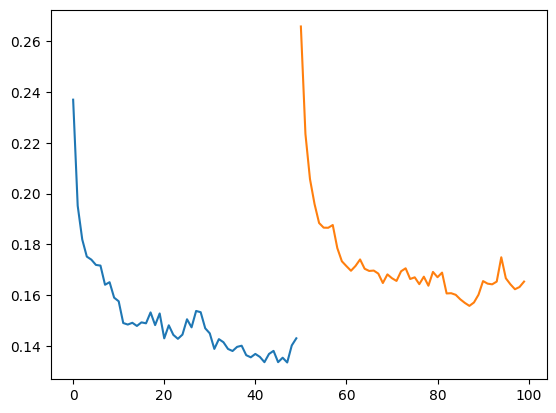

In [216]:
loss_plot(loss)

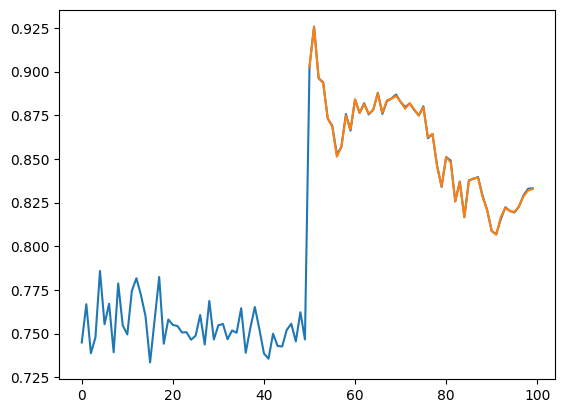

In [217]:
accuracy_plot(acc)

In [ ]:
import importlib
import utils
importlib.reload(utils)
from utils import EWC, ewc_train, normal_train

In [286]:
def ewc_process(model, optimizer, criterion, num_tasks, train_loader_arr, test_loader_arr, epochs, importance, all_train_indices, weight=None):

    loss, acc, ewc = {}, {}, {}
    # getting loaders
    neighbors_arr = [10, 8]
    batch_size = 10
    
    for task in range(num_tasks):
        loss[task] = []
        acc[task] = []

        if task == 0:
            if weight:
                model.load_state_dict(weight)
            else:
                for _ in tqdm(range(epochs)):
                    model.train()
                    loss[task].append(normal_train(model, criterion, optimizer, train_loader_arr[task]))
                    acc[task].append(test(model, test_loader_arr[task]))
        else:
            # need to rewrite this using masking
            old_tasks = []
            for sub_task in range(task):
                # sampling sample_size from old tasks
                old_tasks.extend(random.sample(all_train_indices[sub_task], sample_size))
            # again select 200 randonly
            old_tasks = random.sample(old_tasks, k=sample_size)
            # get dataloader for oldtask
            old_tasks_loader = get_neighbor_loader(data_train, old_tasks, neighbors_arr, batch_size)        
            for _ in tqdm(range(epochs)):
                # start EWC training
                loss[task].append(ewc_train(model, criterion, optimizer, train_loader_arr[task], EWC(model, old_tasks_loader, criterion,sample_size), importance))
                for sub_task in range(task + 1):
                    acc[sub_task].append(test(model, test_loader_arr[sub_task]))

    return loss, acc

In [287]:
import importlib
import utils
importlib.reload(utils)
from utils import EWC, ewc_train, normal_train

In [288]:
gcnModel = Net(64).to(device)
optimizer = torch.optim.Adam(gcnModel.parameters(), lr= 0.01)
criterion = torch.nn.BCELoss()

In [289]:
#parameters for EWC
importance = 1000
sample_size = 500
num_tasks = 2
epochs = 50

In [290]:
loss_ewc, acc_ewc = ewc_process(gcnModel, optimizer, criterion, num_tasks, train_loader_arr, test_loader_arr, epochs, importance, all_train_indices, weight=None)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [15:28<00:00, 18.57s/it]


In [295]:
#loss_ewc

In [292]:
def loss_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, (t + 1) * epochs)), v)
    # possibility of an outlier in data reducing the y_lim to 3

def accuracy_plot(x):
    for t, v in x.items():
        plt.plot(list(range(t * epochs, num_tasks * epochs)), v)  

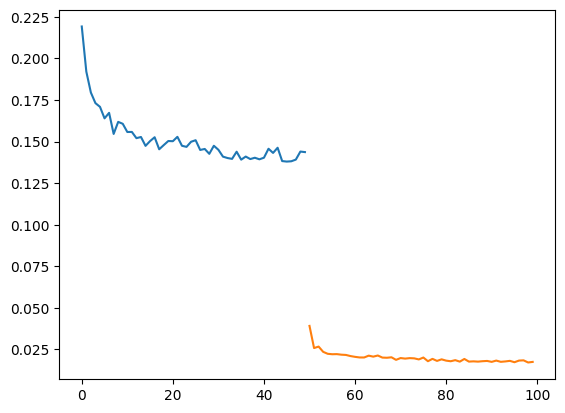

In [293]:
loss_plot(loss_ewc)

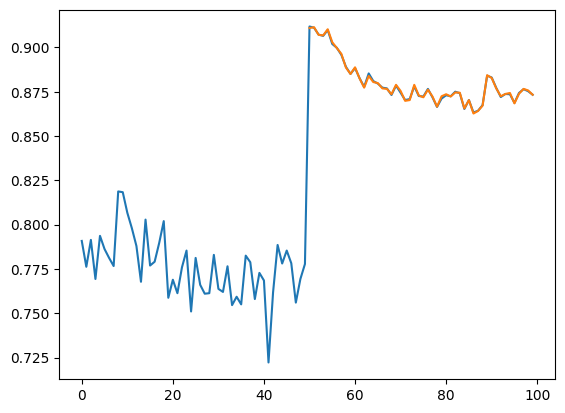

In [294]:
accuracy_plot(acc_ewc)

## Applying Cros validation

In [ ]:
def cross_val_loader(data_train, train_indx, val_indx, batch_size, neighbors_arr):

    # train loader
    cross_val_train_loader=NeighborLoader(
        data_train,
        input_nodes=train_indx,
        num_neighbors=neighbors_arr, #around 70 nodes at a time -> 10 * 5 = 50 and 5 * 4 = 20 -> 50 + 20 = 70
        batch_size=batch_size,
        replace=False,
        shuffle=True
    )

    # test loader
    cross_val_test_loader=NeighborLoader(
        data_train,
        input_nodes=val_indx,
        num_neighbors=neighbors_arr,  
        batch_size=batch_size,
        replace=False,
        shuffle=True
    )

    return cross_val_train_loader, cross_val_test_loader

In [37]:
def kfold_cross_validation(data_train, k, cross_val_train_indx):
    
    # simple kfold-cross validation
    # could not use stratified k-fold-cross validation
    n_splits = 5  # Number of folds
    kf = KFold(n_splits=n_splits)
    
    # run cross val on this indices array 
    for fold, (train_indx, val_indx) in enumerate(kf.split(cross_val_train_indx)):
        
        # reverse the train_indx and val_indx to binary array of size len(data_train.x)
        recreated_train_mask = torch.zeros(data_train.num_nodes)
        recreated_val_mask = torch.zeros(data_train.num_nodes)
        for i in train_indx: recreated_train_mask[i] = True
        for i in val_indx: recreated_val_mask[i] = True
            
        # create new train and test loaders now
        batch_size = 5
        neighbors_arr = [5, 2]
        cross_val_train_loader, cross_val_test_loader = cross_val_loader(data_train, recreated_train_mask, recreated_val_mask, batch_size, neighbors_arr)

        # create GNN model
        gcnModel = Net(64).to(device)
        optimizer = torch.optim.Adam(gcnModel.parameters(), lr= 0.01)
        criterion = torch.nn.BCELoss()
        #writer = SummaryWriter()
        
        # trainin the GNN model
        print("Fold", fold, " training")
        train(gcnModel, optimizer, criterion, cross_val_train_loader, epochs=10)
        writer.close()

        # evaluating the GNN model
        print("Fold", fold, " testing")
        evaluate(gcnModel, cross_val_test_loader)

### Training using Cross validation

In [4]:
# cross_val_train_indx = data_train.train_idx

In [1]:
# kfold_cross_validation(data_train, k=5, cross_val_train_indx=cross_val_train_indx)

In [3]:
# CUDA error: device-side assert triggered
# CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
# For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
# Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.

## Hyperparameter tuning

### Bayesian search

In [ ]:
from skopt import BayesSearchCV

In [ ]:
from skopt import BayesSearchCV

In [ ]:
n_iter = 70

In [ ]:
param_grid = {
    "classifier__learning_rate": (0.0001, 0.1, "log-uniform"),
    "classifier__n_estimators": (100,  1000) ,
    "classifier__max_depth": (4, 400) 
}

In [ ]:
reg_bay = BayesSearchCV(estimator=pipe,
                    search_spaces=param_grid,
                    n_iter=n_iter,
                    cv=5,
                    n_jobs=8,
                    scoring='roc_auc',
                    random_state=123)

In [ ]:
model_bay = reg_bay.fit(X, y)